<center> 
    <h1>DCGAN 을 이용한 자동 글자 생성(Font Generation) </h1>
</center>

<h3 style='color:green'> DCGAN 이란 ? </h3>

DCGAN (Deep Convolutional Generative Adversarial Networks)은 CNN 과 GAN이 복합된 것으로 GANs training 과 더 나은 결과물을 생성하기 위해 2015년에 소개 되었다.

[DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf)

다음은 DCGAN paper 에 소개된 자료이다. <br><br>

<img src="../Figures/DCGAN-Guide-lines.png" width=600 height=600 />

위 논문 내용에 대한 설명임(https://greeksharifa.github.io/generative%20model/2019/03/17/DCGAN/)

3장 접근법과 모델 아키텍처(Approach and Model Architecture)

GAN에 CNN을 써서 이미지 품질을 높이려는 시도는 지금까지 성공적이지 못했다.

우리는 많은 시도 끝에 다양한 데이터셋에서 안정적인 그리고 더 높은 해상도의 이미지를 생성하는 모델 구조를 찾아내었다.

핵심은 다음 내용을 CNN 구조에 적용시키는 것이다.

1. max-pooling과 같은 미분 불가능한 레이어를 strided convolution으로 바꿔 spatial downsampling이 가능하게 한 것이다.
   이는 G에 사용된 것이고, D에는 upsampling이 가능하게 바꿨다.
2. FC(Fully Connected) Layer를 없애고 convolution layer로 바꾸는 것이다.
3. Batch Normalization을 사용하여 학습을 안정화시킨다(참고: 2019년 현재 BN은 거의 필수처럼 되어 있다).
   이는 weight 초기화가 나쁘게 된 경우와 깊은 모델에서 gradient flow를 도우며, 
   학습 초기에 잘못된 방향으로 학습이 진행되어 망하는 경우를 막아준다. 
4. 또한 sample이 요동치는 것을 막기 위해 G의 출력 레이어와 D의 input layer에는 넣지 않았다(이건 많은 시도 끝에 알아낸 듯).
5. G에서는 activation function으로 ReLU를 사용하고 마지막 레이어에는 tanh를 사용한다. 
   Bounded activation(tanh)은 더 빠르게 수렴하고 학습샘플의 분포를 따라갔다. 
   D에는 Leaky ReLU를 사용하여 높은 해상도를 만들 수 있게 하였다. 이는 GAN과 다른 부분이다.


Generator 구조(architecture)

<img src="../Figures/DCGAN_arch.PNG" width=600 height=600 />

<img src="../Figures/DCGAN_d_g_fig.PNG" width=600 height=600 />


GAN 이해 참고자료(https://velog.io/@tobigs-gm1/basicofgan)

<h3 style='color:green'> 실습 개요 </h3>

본 실습은 영어 alphabet dataset 을 사용하여 DCGAN 으로 training 시켜서 새로운 스타일로 영어
alphabet dataset 을 생성하는 것이다.

다음은 **중점 실습 내용**임

<ol>
    <li>Import libraries </li>
    <li>Dataset 준비</li>
    <li>Network architecture</li>
    <li>Loss and optimizer</li>
    <li>Training</li>
    <li>시각화(Creating a GIF)</li>
</ol>    

<h3>Import libraries</h3>


In [4]:
import tensorflow as tf
tf.__version__

'2.4.1'

GIF image 생성을 위하여 imageio 필요

다음 코드 실행

In [4]:
pip install -q imageio

Note: you may need to restart the kernel to use updated packages.


In [5]:
# 기타 모듈 Import
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pathlib
from tensorflow.keras.initializers import RandomNormal 

from IPython import display

<h3 style='color:green'>Dataset 준비</h3>

실습을 위해 자체 데이터 셋을 만들어 봅시다.

"data_generation" 이름으로 root directory("GANs_실습_pjk") 아래 폴더 만들고

그 아래 다음 폴더 생성

<ul>
    <li>fonts (TrueType font files)</li>
    <li>labels (character labels)</li>
    <li>tools(fonts and labels 을 이용하여 font images를 생성하는 python files)</li> 
</ul>
이제 cmd terminal을 열고 명령들을 실행해 봅시다.

먼저 conda 방으로 들어가서 지금의 directory 로 변경하고(cd) 다음 명령 실행

<code>python ./data_generation/tools/실습-2-DCGAN/실습2-dataset-generator.py</code><br><br>
위 명령은 root directory 아래 "실습2-image-data/font-images" 폴더를 생성하고 DCGAN training 을
위한 64x64 사이즈의 이미지를 fonts 폴더에 있는 font style 수(N) 만큼 생성하여 N x 26(labels
directory 에 있는 character label 수 = 알파벳 수) 이미지를 저장시킴
 

Ok!?. 다음은 data input pipeline을 만들고 data 를 load 합시다.

먼저 관련 image directory path 를 setup 하기위해 다음 명령 실행시킴

* TensorFlow input pipelines API 참조  
<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset" target="_blank">Dataset api</a> <br>

In [6]:
os.getcwd()

'C:\\Users\\Owner\\Desktop\\숭실대\\논문_font\\font_test\\GANs_실습_pjk\\실습_2_DCGAN'

In [7]:
# input image path set up
SCRIPT_PATH = os.path.join(os.getcwd())
path_to_img_dir = os.path.join(SCRIPT_PATH, '../실습2-image-data/font-images') # 영어 이미지
# path_to_img_dir = os.path.join(SCRIPT_PATH, '../font-images_512hgl') # 한글 이미지

In [8]:
# Counting the total number of font images on our image directory
data_dir = pathlib.Path(path_to_img_dir)
img= sorted(glob.glob('../실습2-image-data/font-images/*.png'))
image_count = len(img)
print(image_count)

26


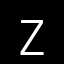

In [9]:
# Let's display out any random image from the image direcotory
# images = list(sorted(data_dir.glob('*.png')))
PIL.Image.open(str(img[-1]))
# img[1]

이미지 데이터를 다루기(manipulate) 위해서 64x64x1 차원의 numpy array 로 변경

In [10]:

def get_name(path):                #  file name 가져오기
    
    name, typeis = os.path.splitext(os.path.basename(path))
    return name

def get_imgs_labels(input_dir):    # imgs_labels 가져와서 각각 이미지를 numpy array 로 반환
    
    if input_dir is None or not os.path.exists(input_dir):
        raise Exception("input_dir does not exist")

    input_paths = glob.glob(os.path.join(input_dir, "*.png"))

    if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

    if all(get_name(path).isdigit() for path in input_paths):
        input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
    else:
        input_paths = sorted(input_paths)

    training_data = []
    
    for path in input_paths:
        image = PIL.Image.open(path).resize((64,
                64),PIL.Image.ANTIALIAS)
        training_data.append(np.asarray(image))
    training_data = np.reshape(training_data,(-1,64,64,1))
    
    return np.asarray(training_data)

In [11]:
train_images = get_imgs_labels(data_dir)

In [12]:
# Lets reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 64,64,1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print(train_images.shape)

(26, 64, 64, 1)


In [13]:
BUFFER_SIZE = 60000
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

위 코드는 tf.data api를 이용하여 <b>tf.data.Dataset.from_tensor_slices()</b> 명령으로 
dataset loading
모든 데이터는 numpy array format, reshaped 와 normalization 을 거쳐 input data 완성

<h3 style='color:green'>Network 구조(architecture)</h3>

GAN 은 Generator 와 Discriminator 로 구성되어 있음.

### Generator

generator 는 random (a seed) 에서 tf.keras.layers.Conv2DTranspose (upsampling) layers 사용하여 하나의 image 생성.

a Dense layer 에서 시작하여 몇번의 upsample 과정을 거치며 원하는 image size (64x64x1)로 이미지 생성.

각 layer에서는 tf.keras.layers.ReLU activation 을 사용하고 마지막에는 tanh 사용. 

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*256,activation="relu",input_shape=(100,)))
    model.add(layers.Reshape((4,4,256)))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    # Final CNN layer
    model.add(layers.Conv2D(1,kernel_size=3,padding="same"))
    model.add(layers.Activation("tanh"))

    return model

random noise 를 넣어서 결과를 보자 (아직 trained 되지 않은 상태의 Generator outputs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0

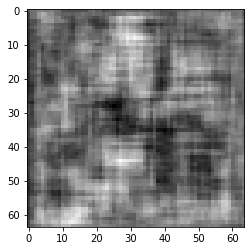

In [15]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

Discriminator(D) 는 CNN-기반 image classifier. 
    
    D 는 sigmoid activation function 을 이용하여 0.5 기준으로 real(1) and fake(0) 로 이진분류한다(binary classification)
    
<img src = "../bce.png" width=500px>    

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=[64, 64, 1], 
                     padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [17]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)       

<h3 style='color:green'>Loss and optimizer</h3>

#### Loss Function

<img src="../loss.png" width=500>

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()   # cross entropy loss 계산

### Discriminator Loss

real images 에 대한 D's predictions             : an array of 1s    
fake (generated) images 에 대한 D's predictions : an array of 0s.

In [19]:
discriminator(generated_image)
cross_entropy(tf.ones_like(generated_image), generated_image)

<tf.Tensor: shape=(), dtype=float32, numpy=6.5733747>

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

<h3 style='color:green'>Generator Loss</h3>

G's loss 값은 얼마나 D를 잘 속이는 값이다. 즉 D 로 하여금 fake images(generated output)를 real (or 1)로 인식토록 하는 것임.   ㄸ따라서 discriminators decisions 과 the generated images 의 an array of 1s 과 비교한다.

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

<h3 style='color:green'> Generator and Disriminator optimizers </h3>  

#### two networks separately.

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

<h3 style='color:green'>Saving model / checkpoints </h3>

#### save and restore our trained model   

다음에 불러와서 다시 처음부터 training하면 많은 시간 소비 => 방지하는 방법으로 다음과 같이   
checkpoint 를 설정해 두면 매번 훈련없이 원하는 곳으로 바로 가서 실행할 수 있음


In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<h3 style='color:green'>Training </h3>

data pipeline, network architecture, losses, optimizers, 등등  model training 준비 완료 

#### Define the training loop

In [25]:
EPOCHS = 10   # 1000 많은 시간 소요
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim]) # reuse this seed overtime (so it's easier) 
                                                               # to visualize progress in the animated GIF)

training loop는 generator가 random seed input 받아서 시작함. (seed 는 image 생성때 사용됨)  
discriminator 는 real images (training set에서 받음) 와 fakes images (generator에서 생성한것)을 구분함.  
loss 는 각각 계산되고, gradients 는 generator 와 discriminator update에 사용됨

In [26]:
@tf.function # This annotation causes the function to be "compiled".
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, noise_dim])

  # Record operations for automatic differentiation.
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    # Calculate gradients of both networks seperately
    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    # Apply the gradients (Training) manually modifying weights manually
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                                     epoch + 15,
                                     seed)

        print ('Time for epoch {} is {} sec generator loss is {} and Discriminator loss is {}'.format(epoch + 1, time.time()-start, g_loss, d_loss))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

<b>Generate and save images</b>  
save an image every epoch.

In [28]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

<h3 style='color:green'>Train the model  </h3>

train() method 를 이용하여 generator 와 discriminator 동시에 훈련시킴

generator 와 discriminator 는 같은 비율로 점점 좋아짐 (어느 하나가 성능이 급격히 좋아지지 않음)

training 시작때 generated image 는 random noise 처럼 보이지만 training 이 진행되면서 generated 이미지는 점점 real 을 닮아감. 

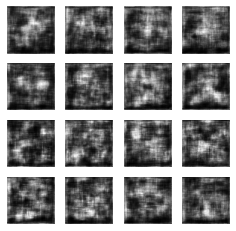

In [29]:
train(train_dataset, EPOCHS)

Now lets restore our checkpoints

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<h3 style='color:green'>Create a GIF</h3>  

GIF image : noise 부터 최종 alphabets 이미지 생성까지의 이미지(참고용)


In [31]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

Use imageio to create an animated gif using the images saved during training.

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [34]:
pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.



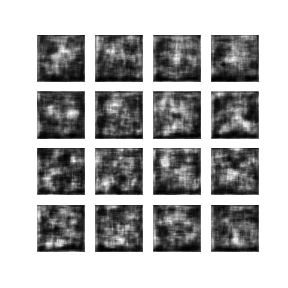

In [35]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## DCGAN 실습종료